In [1]:
from fastai.tabular.all import *
from sklearn.model_selection import train_test_split

## Preprocessamento dos dados

In [2]:
df = pd.read_csv('data/challenge_set_updated_v8.csv').replace([np.inf, -np.inf], np.nan)
dmin, dmax = df.tow.min(), df.tow.max()
df.tow = (df.tow - dmin) / (dmax - dmin)
cat_names = ['aircraft_type', 
             'wtc', 
             'airline',
             'offblock_hour',
             'offblock_minute', 
             'offblock_day_of_week',
             'offblock_month',
             'offblock_week_of_year', 
             'offblock_season', 
             'arrival_hour',
             'arrival_minute',
             'is_offblock_weekend',
             'is_offblock_rush_hour',
             'flight_duration_category',                       
             'adep_region', 
             'ades_region', 
             'same_country_flight',
             'same_region_flight',                        
             'flight_direction',
             'is_intercontinental',
             'Manufacturer',
             'Model_FAA',
             'Physical_Class_Engine',
             'FAA_Weight',
             'adep_geo_cluster',
             'ades_geo_cluster']
cont_names = list(set(df.columns) - set(cat_names) - set(['tow']))
df.head()

,aircraft_type,wtc,airline,taxiout_time,flown_distance,track_variation_ARR_100,track_variation_DEP_100,track_variation_ENR,average_vertical_rate_ARR_100,average_vertical_rate_DEP_100,...,Altitude_adep,Latitude_ades,Longitude_ades,Altitude_ades,altitude_difference,bearing,elevation_gradient,adep_geo_cluster,ades_geo_cluster,tow
0,A320,M,a73f82288988b79be490c6322f4c32ed,18.0,321,124.339907,39.704139,2.102124,-1276.005427,1683.211169,...,25,51.843,-8.492,154,129,277.346455,0.232363,3,13,0.118329
1,B772,H,5543e4dc327359ffaf5b9c0e6faaf0e1,13.0,4193,179.318890,8.910306,76.029652,-858.158167,1682.557205,...,4,25.793,-80.291,3,-1,285.530704,-0.000133,10,18,0.506854
2,A333,H,8be5c854fd664bcb97fb543339f74770,15.0,3770,179.638848,32.391881,85.115541,-791.849866,840.240481,...,38,41.979,-87.904,204,166,305.643136,0.024214,5,1,0.640496
3,B788,H,5543e4dc327359ffaf5b9c0e6faaf0e1,11.0,3607,0.208347,36.998783,101.712676,-690.489814,1851.136442,...,432,39.872,-75.241,12,-420,296.005451,-0.065017,12,9,0.424133
4,A21N,M,a73f82288988b79be490c6322f4c32ed,14.0,305,NaN,174.878799,NaN,NaN,2754.662045,...,74,51.477,-0.461,25,-49,116.445141,-0.109150,13,3,0.164617


## Modelo (com pre-processamento auto)

In [3]:
idx_train, idx_val = train_test_split(range_of(df), test_size=0.05, random_state=42)
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                   cat_names=cat_names, cont_names=cont_names,
                   y_names='tow',
                   splits=(L(idx_train), L(idx_val)))
dls = to.dataloaders(bs=128)

In [5]:
rmse.func = lambda x, y: torch.sqrt(F.mse_loss(x, y)) * (dmax - dmin)
learn = tabular_learner(dls, y_range=(df.tow.min(), df.tow.max()), metrics=rmse)

SuggestedLRs(valley=0.005248074419796467)

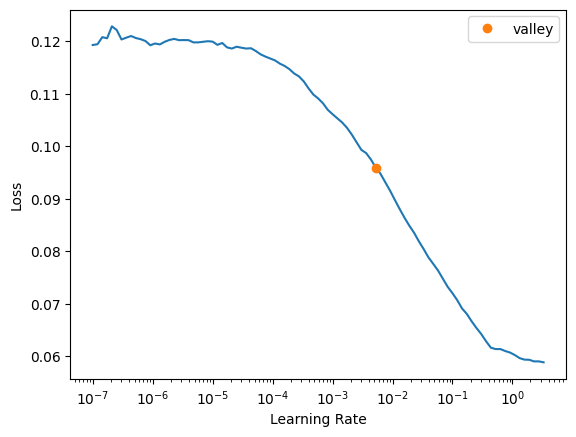

In [6]:
learn.lr_find()

In [7]:
learn.fit_one_cycle(20, lr_max=0.005, cbs=[
        EarlyStoppingCallback(monitor='valid_loss', min_delta=0, patience=6),
        SaveModelCallback(monitor='valid_loss', fname='mlp_v8_default')])

epoch,train_loss,valid_loss,_rmse,time
0,0.000449,0.000882,9990.519531,00:37
1,0.000369,0.000892,10046.682617,00:35
2,0.000312,0.000194,4687.553223,00:37
3,0.000276,0.000199,4746.143066,00:38
4,0.000248,0.000184,4558.124023,00:36
5,0.000233,0.000413,6833.965332,00:39
6,0.000208,0.000217,4958.250977,00:38
7,0.000210,0.000142,4006.550293,00:39
8,0.000219,0.000165,4319.066895,00:38
9,0.000186,0.000136,3920.800537,00:38


Better model found at epoch 0 with valid_loss value: 0.0008820803486742079.
Better model found at epoch 2 with valid_loss value: 0.00019418890587985516.
Better model found at epoch 4 with valid_loss value: 0.00018361335969530046.
Better model found at epoch 7 with valid_loss value: 0.00014186424959916621.
Better model found at epoch 9 with valid_loss value: 0.00013585681153926998.
Better model found at epoch 11 with valid_loss value: 0.00012827746104449034.
No improvement since epoch 11: early stopping


In [13]:
learn.load('mlp_v8_default')
learn.validate()

/home/gabriel/.pyenv/versions/3.11.7/lib/python3.11/site-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


(3828.759726483375, 0.00051047624, 0.011370691, 0.00051047624)

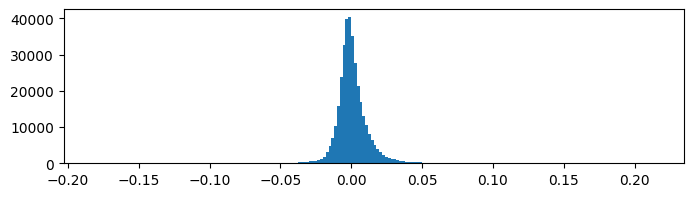

In [8]:
plt.figure(figsize=(8, 2))
preds_train, real_train = learn.get_preds(ds_idx=0)
diff_train = (preds_train - real_train).numpy()
plt.hist(diff_train, bins=200)
np.sqrt(np.mean(diff_train**2)) *(dmax-dmin), diff_train.mean(), diff_train.std(), np.clip(diff_train, -5000, 5000).mean()

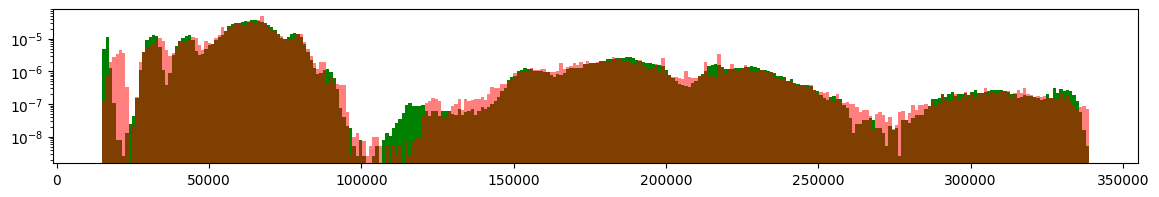

In [9]:
plt.figure(figsize=(14, 2))
nums, bins, f = plt.hist(preds_train.numpy()*(dmax-dmin)+dmin, bins=300, density=True, color='g', log=True)
plt.hist(df['tow']*(dmax-dmin)+dmin, bins=bins, alpha=0.5, color='r', density=True, log=True);

## Validação

(3809.8616, 143.15852, 3807.171, -7.116401)

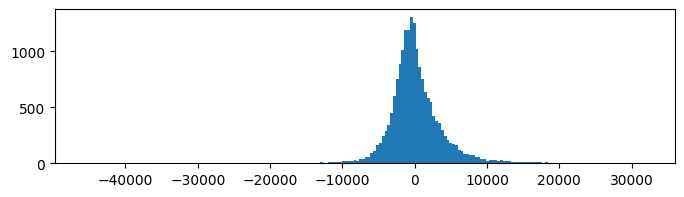

In [10]:
plt.figure(figsize=(8, 2))
preds_valida, real_valida = learn.get_preds()
diff_valida = (preds_valida - real_valida).numpy() * (dmax-dmin)
plt.hist(diff_valida, bins=200)
np.sqrt(np.mean(diff_valida**2)), diff_valida.mean(), diff_valida.std(), np.clip(diff_valida, -5000, 5000).mean()

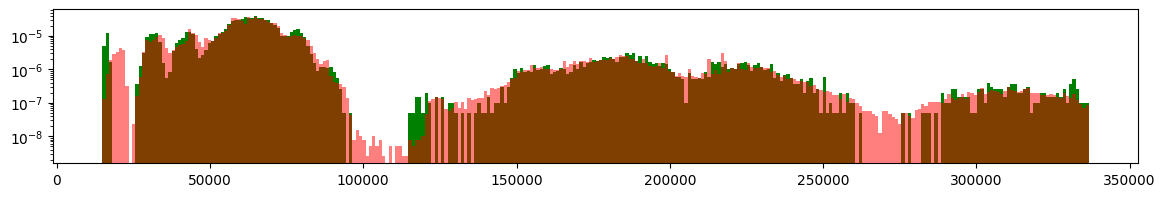

In [11]:
plt.figure(figsize=(14, 2))
nums, bins, f = plt.hist(preds_valida.numpy()*(dmax-dmin)+dmin, bins=300, density=True, color='g', log=True)
plt.hist(df['tow']*(dmax-dmin)+dmin, bins=bins, alpha=0.5, color='r', density=True, log=True);

## Teste

In [12]:
df_test = pd.read_csv('data/submission_set_updated_v8.csv').replace([np.inf, -np.inf], np.nan)
dl_test = learn.dls.test_dl(df_test)
preds, _ = learn.get_preds(dl=dl_test)
valores = preds.numpy()*(dmax-dmin)+dmin

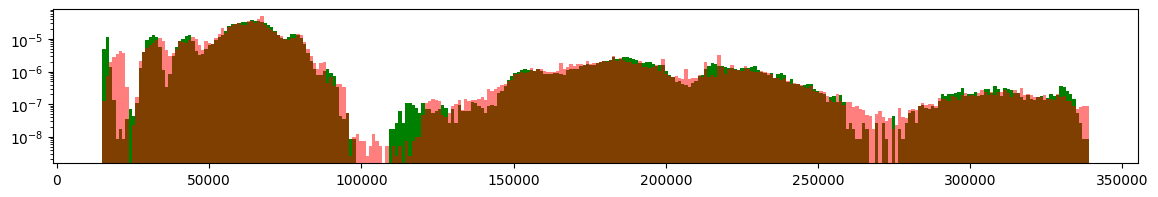

In [13]:
plt.figure(figsize=(14, 2))
nums, bins, f = plt.hist(valores, bins=300, density=True, color='g', log=True)
plt.hist(df['tow']*(dmax-dmin)+dmin, bins=bins, alpha=0.5, color='r', density=True, log=True);

# Submissão

In [22]:
dft0 = pd.read_csv('data/submission_set.csv')
assert len(dft0) == len(dft0)
dft0['tow'] = np.clip(valores.flatten(), 0, df_test.MTOW_kg.values)
dft0[['flight_id', 'tow']].to_csv('mlp.csv', index=False)

In [11]:
# !mc cp ./mlp.csv dc24/submissions/team_tiny_rainbow_v2_7ec66710-1eb8-478e-8976-584c090b6373.csv